Processing file: C:\Users\paras\OneDrive\Desktop\Vs Code\Python\UNSW_2018_IoT_Botnet_Full5pc_1.csv


C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):


Processing file: C:\Users\paras\OneDrive\Desktop\Vs Code\Python\UNSW_2018_IoT_Botnet_Full5pc_2.csv


C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):


Processing file: C:\Users\paras\OneDrive\Desktop\Vs Code\Python\UNSW_2018_IoT_Botnet_Full5pc_3.csv


C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):


Processing file: C:\Users\paras\OneDrive\Desktop\Vs Code\Python\UNSW_2018_IoT_Botnet_Full5pc_4.csv


C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=chunk_size):
C:\Users\paras\AppData\Local\Temp\ipykernel_21704\123917141.py:28: DtypeWarning: Columns (7,9) have 

✅ Done! Combined dataset saved as 'C:\Users\paras\OneDrive\Desktop\combined_dataset.csv'

Final dataset info:
Total rows: 3668522
Total columns: 46
Column names: ['AR_P_Proto_P_Dport', 'AR_P_Proto_P_DstIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_SrcIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'TnBPDstIP', 'TnBPSrcIP', 'TnP_PDstIP', 'TnP_PSrcIP', 'TnP_PerProto', 'TnP_Per_Dport', 'attack', 'bytes', 'category', 'daddr', 'dbytes', 'dpkts', 'dport', 'drate', 'dur', 'flgs', 'flgs_number', 'ltime', 'max', 'mean', 'min', 'pkSeqID', 'pkts', 'proto', 'proto_number', 'rate', 'saddr', 'sbytes', 'seq', 'spkts', 'sport', 'srate', 'state', 'state_number', 'stddev', 'stime', 'subcategory', 'sum']
Attack        99.986997
Non-Attack     0.013003
Name: proportion, dtype: float64


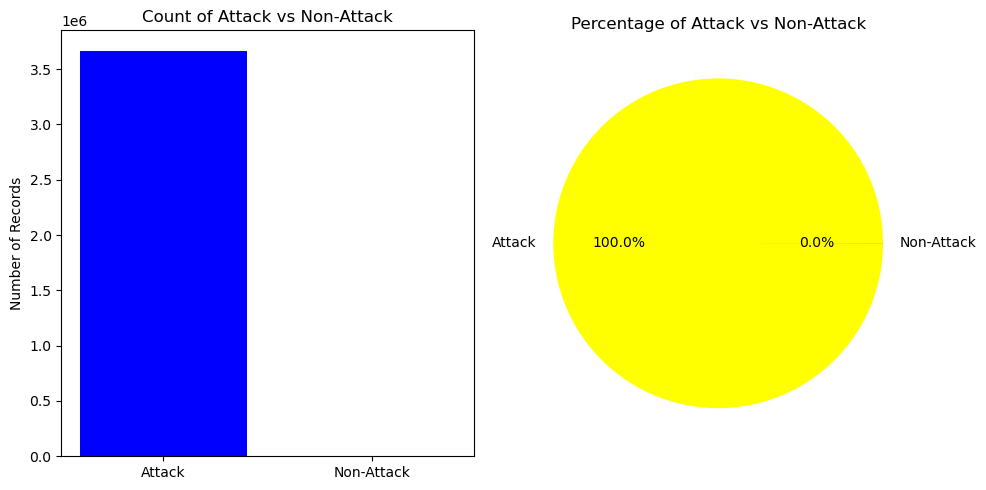


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        95
           1       1.00      1.00      1.00    733610

    accuracy                           1.00    733705
   macro avg       0.98      0.96      0.97    733705
weighted avg       1.00      1.00      1.00    733705



c:\Users\paras\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:59:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy:
Train Accuracy: 1.0000
Test Accuracy:  1.0000


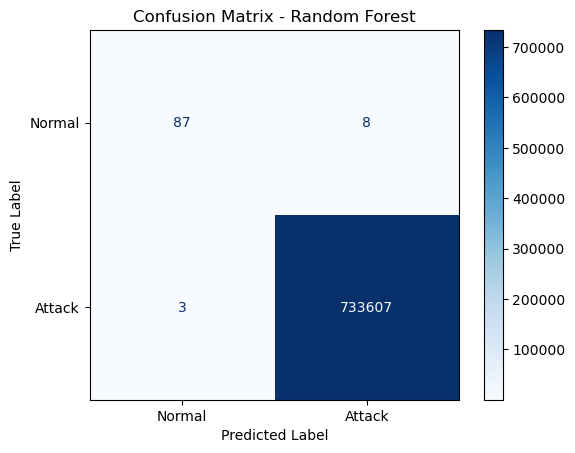

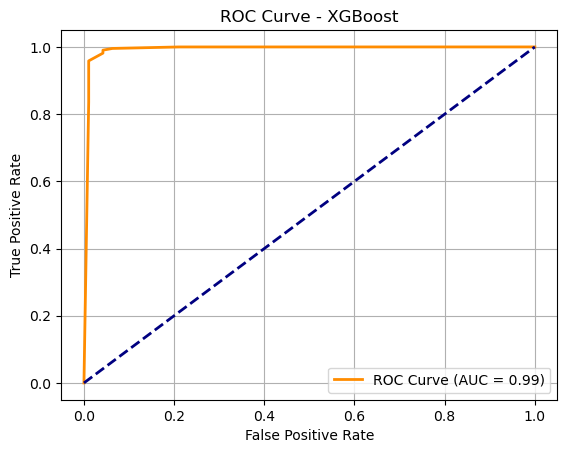

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from xgboost import XGBClassifier

# File paths 
df = [
    r'C:\Users\paras\OneDrive\Desktop\Vs Code\Python\UNSW_2018_IoT_Botnet_Full5pc_1.csv',
    r'C:\Users\paras\OneDrive\Desktop\Vs Code\Python\UNSW_2018_IoT_Botnet_Full5pc_2.csv',
    r'C:\Users\paras\OneDrive\Desktop\Vs Code\Python\UNSW_2018_IoT_Botnet_Full5pc_3.csv',
    r'C:\Users\paras\OneDrive\Desktop\Vs Code\Python\UNSW_2018_IoT_Botnet_Full5pc_4.csv'
]

# Step 2: Parameters
chunk_size = 100000
data_chunks = []

# Step 3: Read each file in chunks
for file in df:
    print(f"Processing file: {file}")
    try:
        for chunk in pd.read_csv(file, chunksize=chunk_size):
            data_chunks.append(chunk)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Step 4: Combine
combined_df = pd.concat(data_chunks, ignore_index=True, sort=True)

# ✅ Step 5: Save locally
output_file = r'C:\Users\paras\OneDrive\Desktop\combined_dataset.csv'
combined_df.to_csv(output_file, index=False)
print(f"✅ Done! Combined dataset saved as '{output_file}'")

# Step 6: Sanity check
print("\nFinal dataset info:")
print(f"Total rows: {combined_df.shape[0]}")
print(f"Total columns: {combined_df.shape[1]}")
print(f"Column names: {combined_df.columns.tolist()}")

# Attack distribution
attack_percentages = combined_df['attack'].value_counts(normalize=True) * 100
attack_percentages.index = ['Non-Attack' if val == 0 else 'Attack' for val in attack_percentages.index]
print(attack_percentages)

# Visualization
counts = combined_df['attack'].value_counts()
labels = ['Non-Attack' if val == 0 else 'Attack' for val in counts.index]
percentages = (counts / counts.sum()) * 100

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, counts, color=['blue', 'green'])
plt.title("Count of Attack vs Non-Attack")
plt.ylabel("Number of Records")

plt.subplot(1, 2, 2)
plt.pie(percentages, labels=labels, autopct='%1.1f%%', colors=['yellow', 'red'])
plt.title("Percentage of Attack vs Non-Attack")

plt.tight_layout()
plt.show()

# Feature selection
features = ['pkts', 'bytes', 'dur']
X = combined_df[features]
y = combined_df['attack']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, test_pred):.4f}")

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest")

# ROC Curve
def plot_roc_curve(model, X_test, y_test, model_name="Model"):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve(xgb_model, X_test, y_test, model_name="XGBoost")


In [2]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.1/150.0 MB 11.8 MB/s eta 0:00:13
   - -------------------------------------- 4.7/150.0 MB 11.4 MB/s eta 0:00:13
   - -------------------------------------- 6.8/150.0 MB 11.3 MB/s eta 0:00:13
   -- ------------------------------------- 8.9/150.0 MB 11.1 MB/s eta 0:00:13
   -- ------------------------------------- 10.5/150.0 MB 10.4 MB/s eta 0:00:14
   --- ------------------------------------ 12.3/150.0 MB 10.0 MB/s eta 0:00:14
   --- ------------------------------------ 14.4/150.0 MB 10.1 MB/s eta 0:00:14
   ---- ----------------------------------- 16.5/150.0 MB 10.1 MB/s eta 0:00:14
   ---- ----------------------------------- 18.6/150.0 MB 10.1 MB/s eta 0:00:13
   ----- ---------------------------------- 20.7/150.0 MB 10.1 MB/s eta 0:00:13
   ------ --------------------------------- 22.8/150.0 MB 10.2 MB/s eta 0:00:13
   ------ --------------------------------- 25.2/150.